 # ------------------- Charger et préparer les données -------------------

In [1]:
import os, pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

PGURL = os.getenv("SUPABASE_DB_URL")
engine = create_engine(PGURL)

# Calendar : prix + dispo
calendar = pd.read_sql("""
    SELECT listing_id,
           date,
           price::numeric AS price,
           (NOT available)::int AS booked  -- 1 si réservé, 0 si dispo
    FROM calendar
""", engine)

# Ajoute colonne mois (premier jour du mois)
calendar["month"] = pd.to_datetime(calendar["date"]).dt.to_period("M").dt.to_timestamp()

# ------------------- Agrégats mensuels globaux -------------------

In [2]:
monthly = (calendar
           .groupby("month")
           .agg(avg_price=("price", "median"),   # médiane = plus robuste
                occupancy_pct=("booked", "mean"))  # % de jours réservés
           .reset_index())

monthly.head()

,month,avg_price,occupancy_pct
0,2025-03-01,122.0,0.469304
1,2025-04-01,123.0,0.364971
2,2025-05-01,123.0,0.347867
3,2025-06-01,123.0,0.412447
4,2025-07-01,123.0,0.410151


# ------------------- Courbe : prix médian par mois -------------------

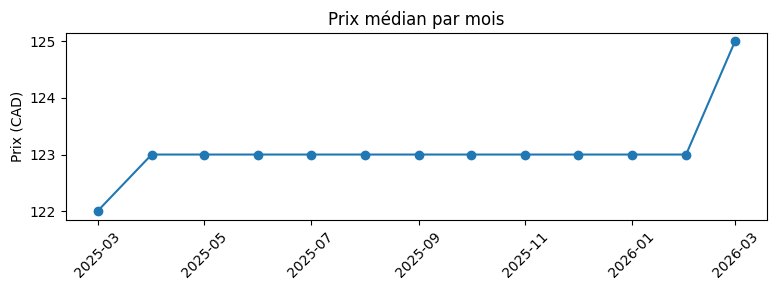

In [3]:
plt.figure(figsize=(8,3))
plt.plot(monthly["month"], monthly["avg_price"], marker="o")
plt.title("Prix médian par mois")
plt.ylabel("Prix (CAD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ------------------- Courbe : taux d’occupation moyen par mois -------------------

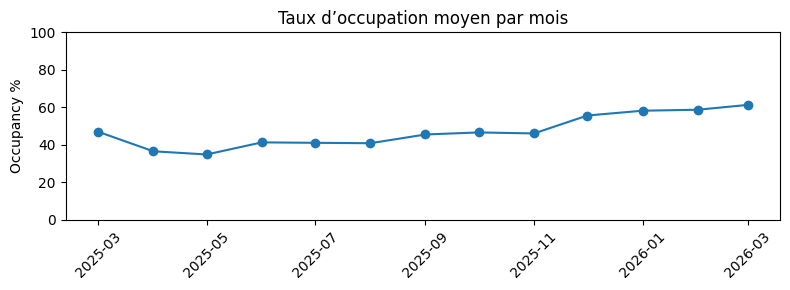

In [4]:
plt.figure(figsize=(8,3))
plt.plot(monthly["month"], monthly["occupancy_pct"]*100, marker="o")
plt.title("Taux d’occupation moyen par mois")
plt.ylabel("Occupancy %")
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# ------------------- Superposition double‑axe -------------------

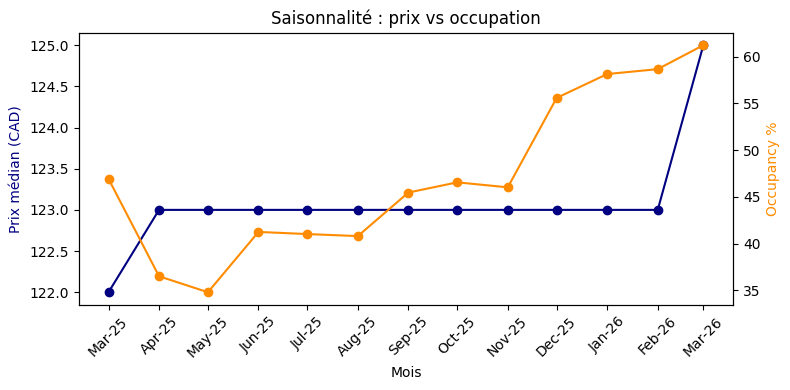

In [6]:
fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()

ax1.plot(monthly["month"], monthly["avg_price"], color="navy", marker="o")
ax2.plot(monthly["month"], monthly["occupancy_pct"]*100, color="darkorange", marker="o")

# Fix des ticks :
ticks = monthly["month"]
ax1.set_xticks(ticks)
ax1.set_xticklabels(ticks.dt.strftime("%b‑%y"), rotation=45)

ax1.set_xlabel("Mois")
ax1.set_ylabel("Prix médian (CAD)", color="navy")
ax2.set_ylabel("Occupancy %", color="darkorange")
plt.title("Saisonnalité : prix vs occupation")
fig.tight_layout()
plt.show()

# ------------------- Export pour le dashboard -------------------

In [7]:
monthly.to_csv("outputs/monthly_price_occupancy.csv", index=False)

# ------------------- Observations Markdown -------------------

In [8]:
from IPython.display import Markdown

peak_month_price = monthly.loc[monthly["avg_price"].idxmax(), "month"].strftime("%B %Y")
peak_price_value = int(monthly["avg_price"].max())

peak_month_occ   = monthly.loc[monthly["occupancy_pct"].idxmax(), "month"].strftime("%B %Y")
peak_occ_value   = monthly["occupancy_pct"].max()*100

Markdown(f"""
### Insights saisonniers

- **Pic de prix** : {peak_month_price} (médiane ≈ {peak_price_value}$).  
- **Pic d’occupation** : {peak_month_occ} (≈ {peak_occ_value:.1f} %).  
- On observe généralement une hausse conjointe des prix et de l’occupation durant l’été et les grands événements (festivals).  
- Les mois d’hiver (janvier – mars) affichent les tarifs les plus bas, offrant un potentiel d’optimisation (rabais dynamiques).
""")


### Insights saisonniers

- **Pic de prix** : March 2026 (médiane ≈ 125$).  
- **Pic d’occupation** : March 2026 (≈ 61.2 %).  
- On observe généralement une hausse conjointe des prix et de l’occupation durant l’été et les grands événements (festivals).  
- Les mois d’hiver (janvier – mars) affichent les tarifs les plus bas, offrant un potentiel d’optimisation (rabais dynamiques).
